`model`: https://drive.google.com/drive/folders/1zqSudSICI97fWn3xCrEHsDjTQAzEFoAN?usp=share_link

`times`: https://drive.google.com/drive/folders/1vWyhUAzjjrVNk5Jmwz7uZaoa6mnDASIE?usp=share_link

In [1]:
device = 'cuda'

In [2]:
import warnings
warnings.filterwarnings("ignore")

try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PREFIX = '/content/drive/MyDrive/m1p'

    IN_COLAB = True
except:
    IN_COLAB = False

Mounted at /content/drive


In [3]:
if IN_COLAB:
    prefix = DRIVE_PREFIX
else:
    prefix = '.'
    
figures = f'{prefix}/figs/v2/basic'
model_path = f'{prefix}/pretrained/model_23.ckpt'
times_path = f'{prefix}/time_measurements/ResNet18HomeMeasurements.csv'

In [4]:
if IN_COLAB:
    ! git clone -qq https://github.com/intsystems/2023-Problem-140.git
    import sys
    sys.path.append('2023-Problem-140/code')

In [5]:
from tqdm import tqdm
from typing import Dict
import time

import torch
import torch.fx
from torch.fx.node import Node

import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('seaborn')

from src.resnet18 import ResNet18
from src.module2graph import GraphInterperterWithGamma
from src.cifar_data import get_dataloaders

In [6]:
class GraphInterperterWithGumbelSoftmaxGamma(GraphInterperterWithGamma):
    def __init__(self, mod, gamma_shift=0.0, temperature=1.0):
        self.gamma_shift = gamma_shift
        self.temperature = temperature
        super().__init__(mod)

    def init_gammas(self):
        i = 0
        gammas = []
        self.gammas_name = {}
        for node in self.graph.nodes:
            if node.op == 'call_module':
                gammas.append(np.random.randn()+self.gamma_shift)
                self.gammas_name[str(node)] = i# перевод в str тут для удобства. в реалньых методах это не нужно
                i+=1                        # да и вообще, тут по идее должен быть тензор/параметр
        self.gammas =  torch.nn.Parameter(torch.as_tensor(gammas), requires_grad = True)
        self.discrete = False 

    def sample_gammas(self, previous=False):
        if self.discrete:
            return self.gammas

        if not previous:
            d = torch.distributions.RelaxedBernoulli(logits=self.gammas, temperature=self.temperature)
            self.last_sample = d.rsample()

        return self.last_sample
        
    def make_gammas_discrete(self):
        self.gammas.data = (self.gammas.data>=0) * 1.0
        self.gammas.requires_grad = False 
        self.discrete = True

Получим претрейн на n эпох

In [7]:
model = ResNet18(num_classes=10).to(device)
model.load_state_dict(torch.load(model_path))

train_dl, test_dl = get_dataloaders(classes=range(10), batch_size=64, img_size=33)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s] 


100%|██████████| 170498071/170498071 [00:05<00:00, 28852824.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

ACC, LOSS, LAT = {'accuracy'}, {'loss'}, {'latency'}
ALL = ACC | LOSS | LAT

@torch.no_grad()
def validate(model, dataloader, device, getters: set=ALL):
    n_true, n_tot = 0, 0
    loss, latency = 0, 0

    for i, (X, y) in enumerate(dataloader):
        if X.shape[0] != 64:
            continue

        y_pred = model(X.to(device))

        n_tot += 64

        if 'accuracy' in getters:
            n_true += (y_pred.argmax(-1) == y.to(device)).sum().item()
        if 'loss' in getters:
            loss += loss_fn(y_pred, y.to(device)).item() * 64
        if 'latency' in getters:
            latency += model.sample_gammas(previous=True).dot(times).item() * 64

    return n_true / n_tot, loss / n_tot, latency / n_tot

In [9]:
base_acc, base_loss, _ = validate(model, test_dl, 'cuda', ACC | LOSS)
base_acc, base_loss

(0.6464342948717948, 1.3685274464197648)

In [10]:
times = pd.read_csv(times_path, index_col=0)
times = torch.tensor(times['mean'], dtype=torch.float32).cuda()
times /= times.sum()

In [11]:
def train_epoch(imodel, optimizer, lambd, dl=train_dl):
    for i, (X, y) in enumerate(dl):
        if X.shape[0] != 64:
            continue

        optimizer.zero_grad()

        y_pred = imodel(X.to(device))
        loss = loss_fn(y_pred, y.to(device)) + lambd * imodel.sample_gammas().dot(times)
        loss.backward()

        optimizer.step()

In [33]:
EPOCHS = 10

lambda_report = {}
imodels = {}

lambds = [*range(10)]

imodel = GraphInterperterWithGumbelSoftmaxGamma(model.eval(), 4, temperature=0.2).to(device)

init_gammas = imodel.gammas

discrete_imodel = GraphInterperterWithGumbelSoftmaxGamma(model.eval()).to(device)

for lambd in tqdm(lambds, total=len(lambds)):
    imodel.gammas = init_gammas
    optimizer = torch.optim.Adam([imodel.gammas], lr=0.02)

    for epoch in range(EPOCHS):
        imodel.train()

        train_epoch(imodel, optimizer, lambd)

        imodel.eval()

        lambda_report.setdefault(f'{lambd}', {})

        acc, _, lat = validate(imodel, test_dl, device, ACC | LAT)        
        
        lambda_report[f'{lambd}'].setdefault('acc_rel', []).append(acc)
        lambda_report[f'{lambd}'].setdefault('lat_rel', []).append(lat)


        discrete_imodel.gammas.data = imodel.gammas.data
        discrete_imodel.make_gammas_discrete()        
        
        acc, _, lat = validate(discrete_imodel, test_dl, device, ACC | LAT)

        lambda_report[f'{lambd}'].setdefault('acc_dis', []).append(acc)
        lambda_report[f'{lambd}'].setdefault('lat_dis', []).append(lat)

    imodels[lambd] = imodel

100%|██████████| 10/10 [34:53<00:00, 209.34s/it]


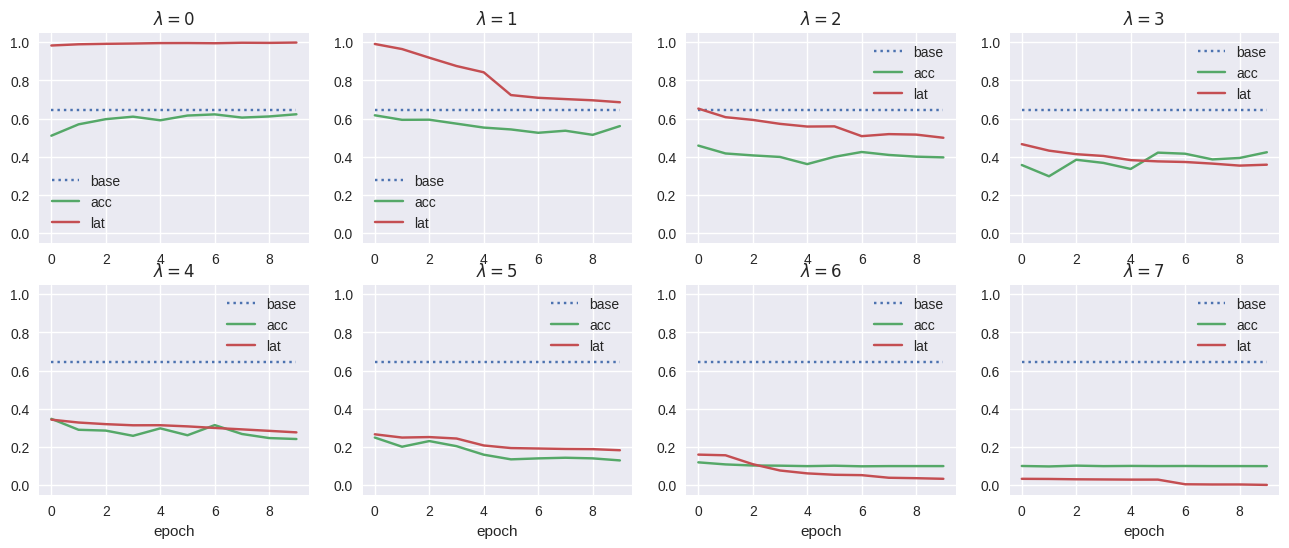

In [34]:
w = 4
fig, axs = plt.subplots(2, w, figsize=(w*4, 6))

for i, key in enumerate(lambda_report):
    if i == 8:
        break
    axs[i//w][i%w].set_title(rf"$\lambda={key}$")
    axs[i//w][i%w].plot([base_acc]*EPOCHS, label='base', ls=':')
    axs[i//w][i%w].plot(lambda_report[key]['acc_rel'], label='acc')
    axs[i//w][i%w].plot(lambda_report[key]['lat_rel'], label='lat')
    axs[i//w][i%w].legend()
    if i >= w:
      axs[i//w][i%w].set_xlabel('epoch')
    axs[i//w][i%w].set_ylim(-0.05, 1.05)


plt.savefig(f'{figures}/convergence_rel.pdf', bbox_inches='tight')

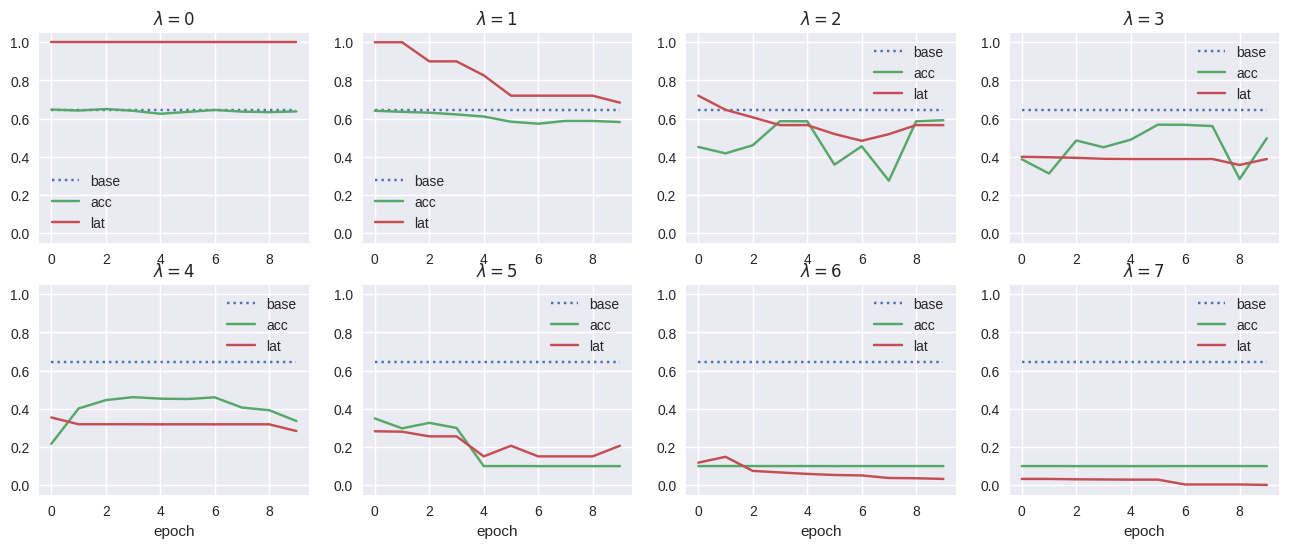

In [35]:
w = 4
fig, axs = plt.subplots(2, w, figsize=(w*4, 6))

for i, key in enumerate(lambda_report):
    if i == 8:
        break
    axs[i//w][i%w].set_title(rf"$\lambda={key}$")
    axs[i//w][i%w].plot([base_acc]*EPOCHS, label='base', ls=':')
    axs[i//w][i%w].plot(lambda_report[key]['acc_dis'], label='acc')
    axs[i//w][i%w].plot(lambda_report[key]['lat_dis'], label='lat')
    axs[i//w][i%w].legend()
    if i >= w:
      axs[i//w][i%w].set_xlabel('epoch')
    axs[i//w][i%w].set_ylim(-0.05, 1.05)


plt.savefig(f'{figures}/convergence_dis.pdf', bbox_inches='tight')

In [36]:
accs = [r['acc_dis'][-1] for l, r in lambda_report.items()]
lats = [r['lat_dis'][-1] for l, r in lambda_report.items()]

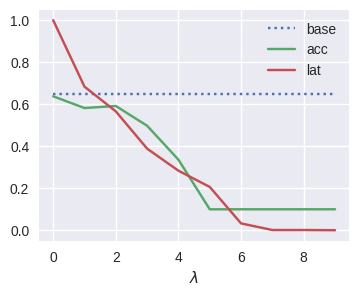

In [37]:
plt.figure(figsize=(4,3))

plt.plot([base_acc] * len(accs), label='base', ls=':')
plt.plot(accs, label='acc')
plt.plot(lats, label='lat')

plt.xlabel('$\lambda$')

plt.legend()

plt.savefig(f'{figures}/acc&lat_vs_lambda.pdf', bbox_inches='tight')

In [38]:
N_RANDOM = 100

random_accs = []
random_lats = []

gammas_prob = torch.tensor([0.5]*60).to(device)

for i in tqdm(range(N_RANDOM), total=N_RANDOM):
    discrete_imodel.gammas.data = torch.bernoulli(gammas_prob)
    acc, _, lat = validate(discrete_imodel, test_dl, device, ACC | LAT)

    random_accs.append(acc)
    random_lats.append(lat)

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


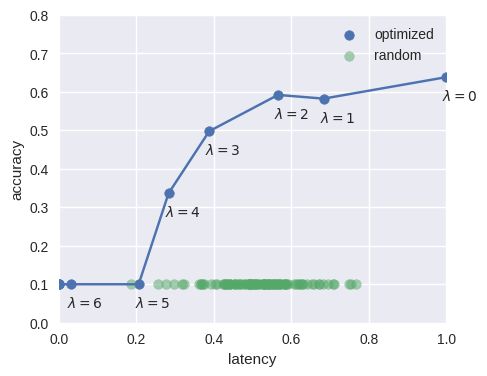

In [42]:
plt.figure(figsize=(5,4))

plt.scatter(lats, accs, label='optimized')
plt.plot(lats, accs)

plt.scatter(random_lats, random_accs, label='random', alpha=0.5)

for i, (lat, acc) in enumerate(zip(lats, accs)):
    if i == 7:
        break
    plt.text(lat-0.01, acc-0.06, rf'$\lambda={i}$')

plt.xlabel('latency')
plt.ylabel('accuracy')

plt.xlim((0,1))
plt.ylim((0,0.8))

plt.legend()

plt.savefig(f'{figures}/acc_vs_lat.pdf', bbox_inches='tight')

In [18]:
!{sys.executable} -m pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 13.1 MB/s eta 0:00:00


In [40]:
from torcheval.metrics.aggregation.auc import AUC

metric = AUC()

metric.update(torch.tensor(lats), torch.tensor(accs))
print(metric.compute().item())
metric.reset()

metric.update(torch.tensor(random_lats), torch.tensor(random_accs))
print(metric.compute().item())
metric.reset()

0.4397848844528198
0.057790208607912064


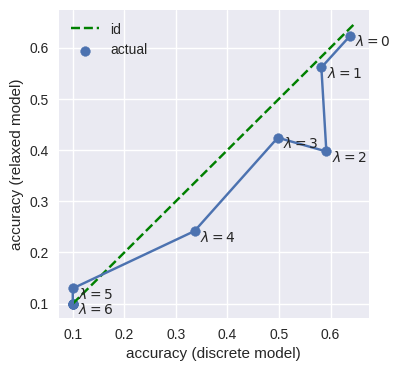

In [43]:
plt.figure(figsize=(4,4))

accs_dis = [r['acc_dis'][-1] for l, r in lambda_report.items()]
accs_rel = [r['acc_rel'][-1] for l, r in lambda_report.items()]

plt.plot([0.1, base_acc], [0.1, base_acc], ls='--', color='green', label='id')
plt.scatter(accs_dis, accs_rel, label='actual')
plt.plot(accs_dis, accs_rel)

for i, (d, r) in enumerate(zip(accs_dis, accs_rel)):
    if i == 7:
        break
    plt.text(d+0.01, r-0.02, rf'$\lambda={i}$')

plt.xlabel('accuracy (discrete model)')
plt.ylabel('accuracy (relaxed model)')

plt.legend()

plt.savefig(f'{figures}/acc_vs_acc.pdf', bbox_inches='tight')